In [95]:
import seaborn as sns
import matplotlib.pyplot as pl
import xarray as xr
import numpy as np
import warnings
warnings.simplefilter('ignore')
import glob
import dask.bag as db
from matplotlib.colors import LogNorm

In [96]:
sns.set()
sns.set_style('white')
pl.rcParams['figure.figsize'] = [12, 12/1.6]

In [97]:
def read_data(infile):
    dset = xr.open_dataset(infile)

    refl_gpm = dset.refl_gpm_grband.values
    refl_gr = dset.refl_gr_weigthed.values
    pir_gr = dset.pir_gr.values
    pir_gpm = dset.pir_gpm.values
    std_refl_gpm = dset.std_refl_gpm.values
    std_refl_gr = dset.std_refl_gr.values
    gr_range = dset.r.values
    height = dset.z.values
    timedelta = dset.timedelta.values
    # (refl_gr < 21) | (refl_gr > 36) |
    pos =  np.isnan(refl_gpm) | np.isnan(refl_gr) | np.isnan(pir_gr) | np.isnan(pir_gpm) | np.isnan(std_refl_gpm) | np.isnan(std_refl_gr) 
    
    return refl_gpm[~pos], refl_gr[~pos], pir_gr[~pos], pir_gpm[~pos], std_refl_gpm[~pos], std_refl_gr[~pos], gr_range[~pos], height[~pos], timedelta[~pos]

In [98]:
# infile = 'first_pass/vmatch.gpm.orbit.0017479.02.20170327.0443.pass0.nc'
refl_thld = 10
# flist = glob.glob(f'gr_{int(refl_thld)}dB/first_pass/*.nc')
flist = [f for f in sorted(glob.glob(f'./gr_{int(refl_thld)}dB/first_pass/vmatch*.nc'))]
bag = db.from_sequence(flist).map(read_data)
rslt = bag.compute()
# rslt = read_data(infile)

refl_gpm = np.array([])
refl_gr = np.array([])
pir_gr = np.array([])
pir_gpm = np.array([])
std_refl_gpm = np.array([])
std_refl_gr = np.array([])
gr_range = np.array([])
height = np.array([])
timedelta = np.array([])

for a, b, c, d, e, f, g, h, i in rslt:
    refl_gpm = np.append(refl_gpm, a)
    refl_gr = np.append(refl_gr, b)
    pir_gr = np.append(pir_gr, c)
    pir_gpm = np.append(pir_gpm, d)
    std_refl_gpm = np.append(std_refl_gpm, e)
    std_refl_gr = np.append(std_refl_gr, f)
    gr_range = np.append(gr_range, g)
    height = np.append(height, h)
    timedelta = np.append(timedelta, i)
    
seconds = 1e-9 * timedelta

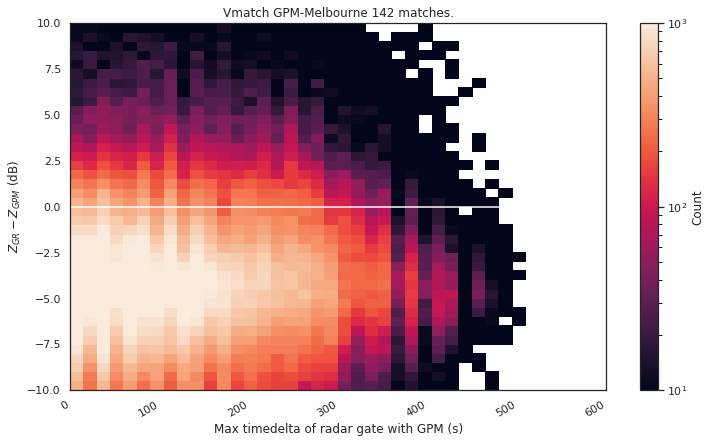

In [99]:
fig = pl.figure()
pl.hist2d(np.abs(seconds), refl_gr.ravel() - refl_gpm.ravel(), range=[[0, 600], [-10, 10]], bins=40, norm=LogNorm(10, 1e3))
pl.axhline(0, color='w')
pl.axes().set(xlabel='Max timedelta of radar gate with GPM (s)', ylabel='$Z_{GR} - Z_{GPM}$ (dB)')
pl.title(f'Vmatch GPM-Melbourne {len(flist)} matches.')
pl.colorbar(label='Count')
fig.autofmt_xdate()
pl.show()

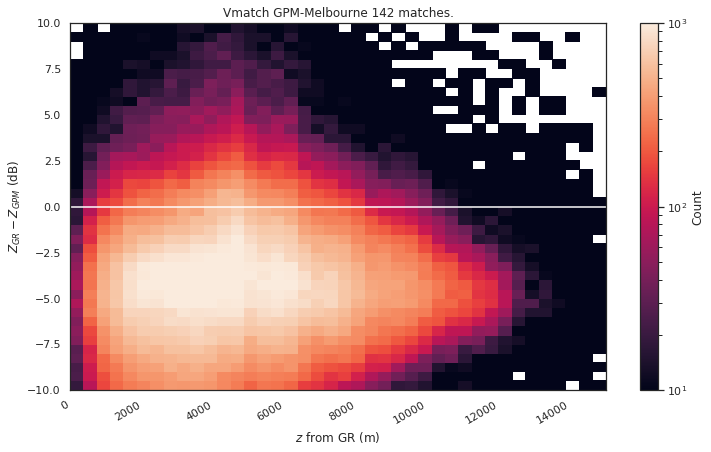

In [100]:
fig = pl.figure()
pl.hist2d(height, refl_gr.ravel() - refl_gpm.ravel(), range=[[0, 15e3], [-10, 10]], bins=40, norm=LogNorm(10, 1e3))
pl.axhline(0, color='w')
pl.axes().set(xlabel='$z$ from GR (m)', ylabel='$Z_{GR} - Z_{GPM}$ (dB)')
pl.title(f'Vmatch GPM-Melbourne {len(flist)} matches.')
pl.colorbar(label='Count')
fig.autofmt_xdate()
pl.show()

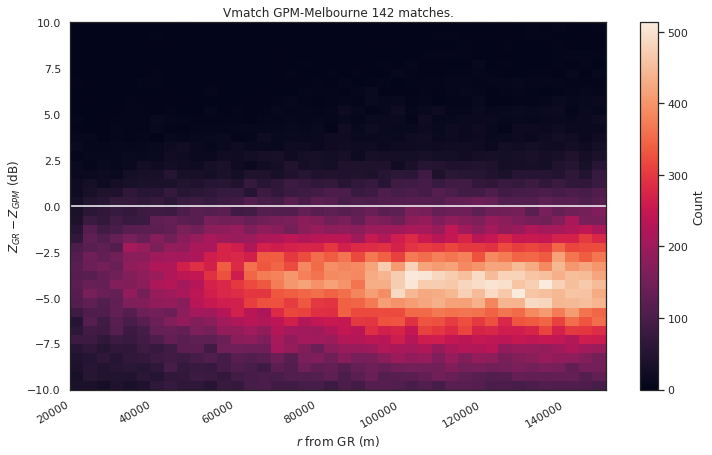

In [101]:
fig = pl.figure()
pl.hist2d(gr_range, refl_gr.ravel() - refl_gpm.ravel(), range=[[20e3, 150e3], [-10, 10]], bins=40)
pl.axhline(0, color='w')
pl.axes().set(xlabel='$r$ from GR (m)', ylabel='$Z_{GR} - Z_{GPM}$ (dB)')
pl.title(f'Vmatch GPM-Melbourne {len(flist)} matches.')
pl.colorbar(label='Count')
fig.autofmt_xdate()
pl.show()

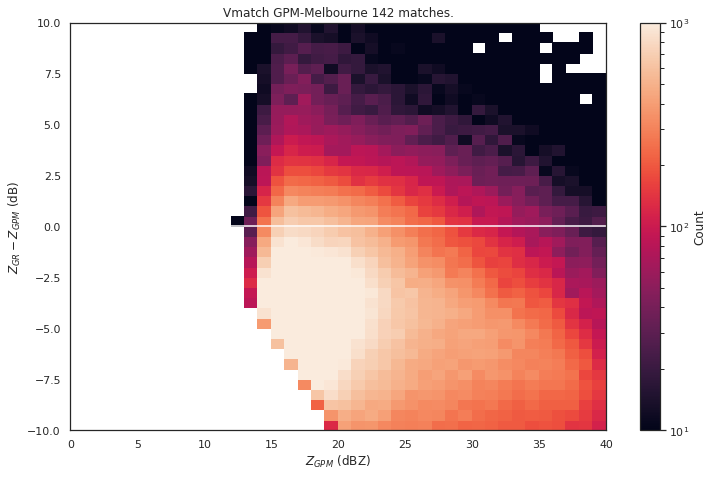

In [102]:
pl.hist2d(refl_gpm.ravel(), refl_gr.ravel() - refl_gpm.ravel(), range=[[0, 40], [-10, 10]], bins=40, norm=LogNorm(10, 1000))
pl.axhline(0, color='w')
pl.axes().set(xlabel='$Z_{GPM}$ (dBZ)', ylabel='$Z_{GR} - Z_{GPM}$ (dB)')
pl.title(f'Vmatch GPM-Melbourne {len(flist)} matches.')
pl.colorbar(label='Count')
pl.show()

In [103]:
h, x, y = np.histogram2d(refl_gr.ravel(), refl_gr.ravel() - refl_gpm.ravel(), range=[[0, 40], [-10, 10]], bins=40)

In [104]:
med = np.array([np.argmax(a) for a in h])

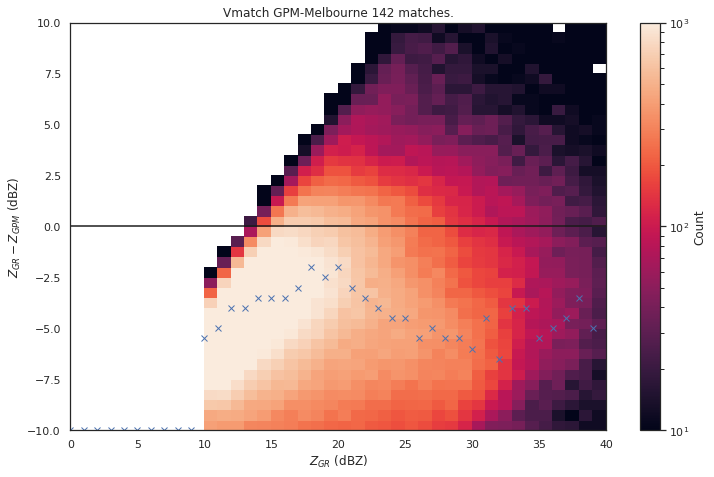

In [105]:
pl.hist2d(refl_gr.ravel(), refl_gr.ravel() - refl_gpm.ravel(), range=[[0, 40], [-10, 10]], bins=40, norm=LogNorm(10, 1000))
pl.plot(y[med], 'x')
pl.axhline(0, color='k')
pl.axes().set(xlabel='$Z_{GR}$ (dBZ)', ylabel='$Z_{GR} - Z_{GPM}$ (dBZ)')
pl.title(f'Vmatch GPM-Melbourne {len(flist)} matches.')
pl.colorbar(label='Count')
pl.show()

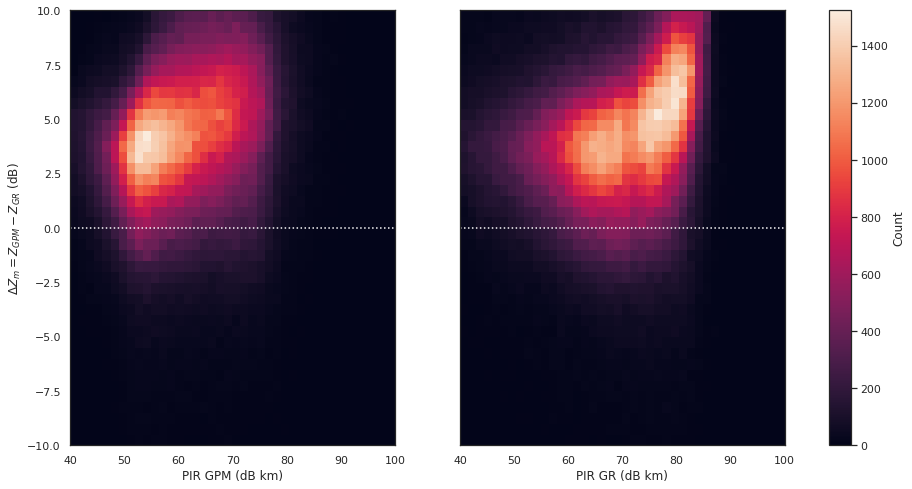

In [119]:
fig, ax = pl.subplots(1, 2, figsize=(16, 8), sharey=True)
ax = ax.ravel()

_, _, _, im = ax[0].hist2d(pir_gpm.ravel(), refl_gpm.ravel() - refl_gr.ravel(), range=[[40, 100], [-10, 10]], bins=40)
ax[1].hist2d(pir_gr.ravel(), refl_gpm.ravel() - refl_gr.ravel(), range=[[40, 100], [-10, 10]], bins=40)
ax[0].set(xlabel='PIR GPM (dB km)', ylabel='$\\Delta Z_m = Z_{GPM} - Z_{GR}$ (dB)')
ax[1].set(xlabel='PIR GR (dB km)')
[a.axhline(0, color='w', linestyle=':') for a in ax]
fig.colorbar(im, ax=ax, label='Count')
# pl.savefig('PIR_melbourne.png',dpi=150)

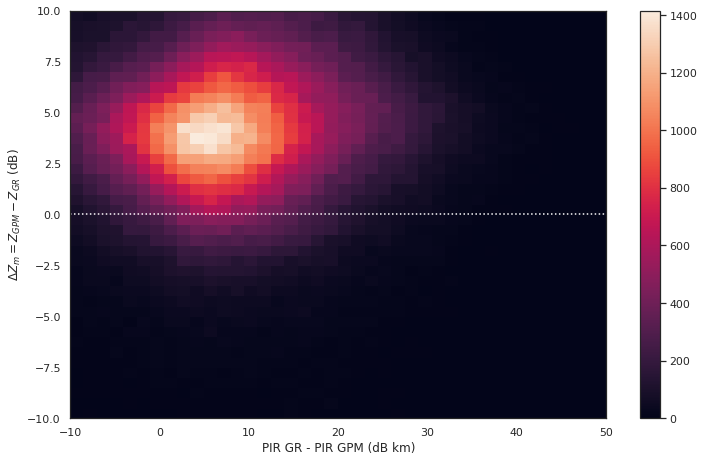

In [120]:
pl.hist2d(pir_gr - pir_gpm, refl_gpm.ravel() - refl_gr.ravel(), range=[[-10, 50], [-10, 10]], bins=40)
pl.axhline(0, color='w', linestyle=':')
pl.axes().set(xlabel='PIR GR - PIR GPM (dB km)', ylabel='$\\Delta Z_m = Z_{GPM} - Z_{GR}$ (dB)')
# pl.title('For PIR GR < $50^{th}$ percentile')
pl.colorbar()
pl.savefig('delta_pir_offset.png', dpi=150)

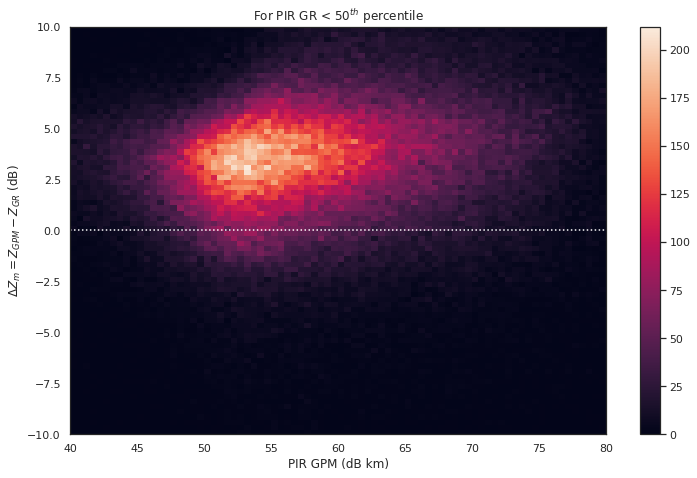

In [108]:
pl.hist2d(pir_gpm[pir_gr < np.median(pir_gr)], (refl_gpm - refl_gr)[pir_gr < np.median(pir_gr)], 
          range=[[40, 80], [-10, 10]], bins=80)
pl.axhline(0, color='w', linestyle=':')
pl.axes().set(xlabel='PIR GPM (dB km)', ylabel='$\\Delta Z_m = Z_{GPM} - Z_{GR}$ (dB)')
pl.title('For PIR GR < $50^{th}$ percentile')
pl.colorbar()
pl.show()

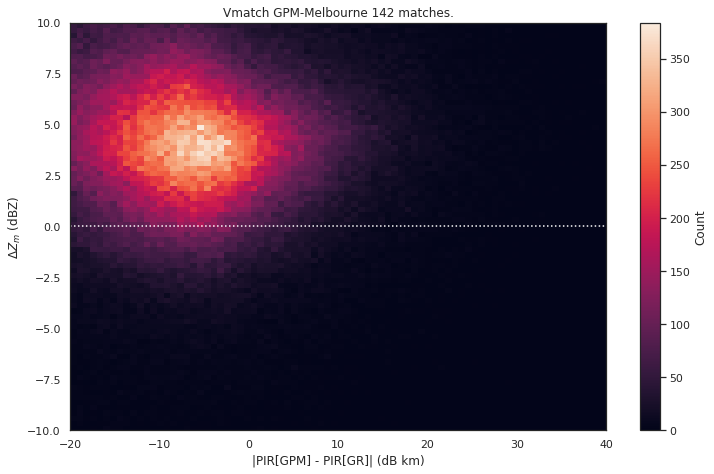

In [109]:
pl.hist2d((pir_gpm - pir_gr), refl_gpm - refl_gr, range=[[-20, 40], [-10, 10]], bins=80)
pl.axhline(0, color='w', linestyle=':')
pl.axes().set(xlabel='|PIR[GPM] - PIR[GR]| (dB km)', ylabel='$\\Delta Z_m$ (dBZ)')
pl.title(f'Vmatch GPM-Melbourne {len(flist)} matches.')
pl.colorbar(label='Count')
fig.tight_layout()
pl.show()

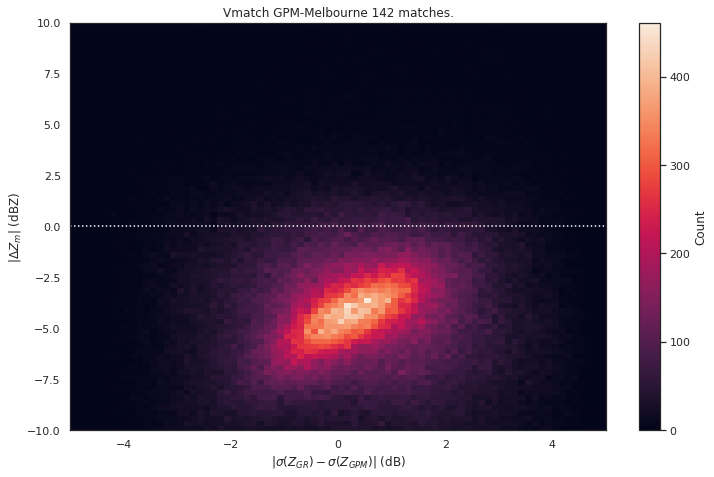

In [114]:
a0 = std_refl_gpm.copy()
a0[(std_refl_gpm <= 0.1) | (std_refl_gpm > 5)] = np.NaN  #| (std_refl_gpm > 5)
a1 = std_refl_gr.copy()
a1[(std_refl_gr == 0) | (std_refl_gr > 5)] = np.NaN
x = (a1 - a0)
y = (refl_gr - refl_gpm)

pl.hist2d(x, y, range=[[-5, 5], [-10, 10]], bins=80)
pl.axhline(0, color='w', linestyle=':')
pl.axes().set(xlabel=r'$|\sigma(Z_{GR}) - \sigma(Z_{GPM})|$ (dB)', ylabel='$|\\Delta Z_m|$ (dBZ)')
pl.title(f'Vmatch GPM-Melbourne {len(flist)} matches.')
pl.colorbar(label='Count')
fig.tight_layout()
pl.show()

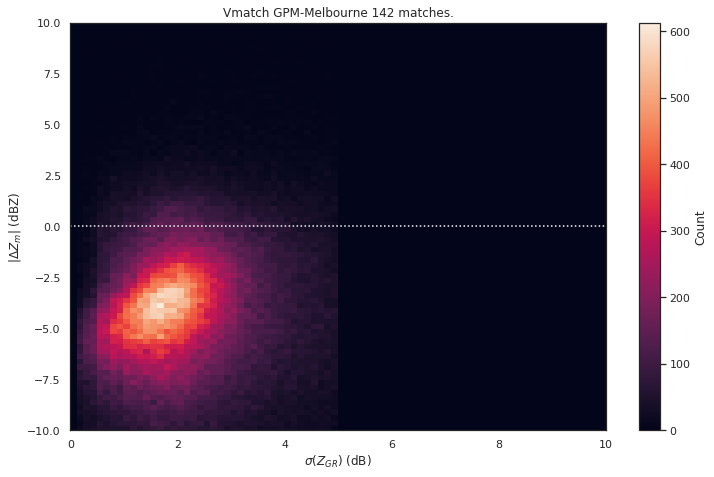

In [115]:
x = (a1)
y = (refl_gr - refl_gpm)

pl.hist2d(x, y, range=[[0, 10], [-10, 10]], bins=80)
pl.axhline(0, color='w', linestyle=':')
pl.axes().set(xlabel=r'$\sigma(Z_{GR})$ (dB)', ylabel='$|\\Delta Z_m|$ (dBZ)')
pl.title(f'Vmatch GPM-Melbourne {len(flist)} matches.')
pl.colorbar(label='Count')
fig.tight_layout()
pl.show()

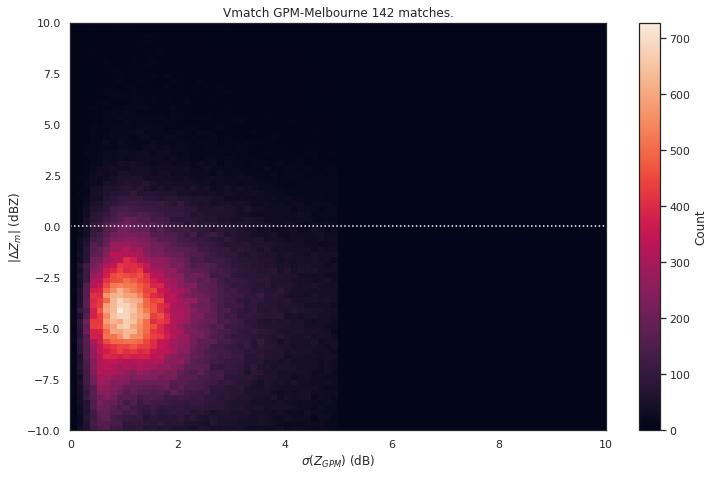

In [116]:
x = (a0)
y = (refl_gr - refl_gpm)

pl.hist2d(x, y, range=[[0, 10], [-10, 10]], bins=80)
pl.axhline(0, color='w', linestyle=':')
pl.axes().set(xlabel=r'$\sigma(Z_{GPM})$ (dB)', ylabel='$|\\Delta Z_m|$ (dBZ)')
pl.title(f'Vmatch GPM-Melbourne {len(flist)} matches.')
pl.colorbar(label='Count')
fig.tight_layout()
pl.show()